# Customer Support Agent with LangGraph and RAG

## 사용하는 기술들

This notebook demonstrates how to build an intelligent customer support system using:
- **LangGraph**
- **Upstage API**
    - LLM: **Solar-pro-v2**
    - RAG: **Vector Search**
- 웹 검색: **Tavily API**

## 학습 목표
1. Solar API를 활용해 Chat, Embedding을 할 수 있습니다.

2. Agentic Workflow를 구현하는 프레임워크인 LangGraph의 핵심 구성 요소(State, Node, Edge)의 역할을 이해하고 직접 구현 할 수 있습니다.

3. Agentic Workflow에서 활용할 Tool을 직접 구현 할 수 있습니다. 

4. RAG, 웹 검색, 조건부 분기 등이 포함된 실무적인 '고객 응대 에이전트'를 직접 구현할 수 있습니다. 이를 통해 복잡한 비즈니스 로직을 워크플로우로 직접 설계하고, LangGraph를 사용해 코드로 구현하는 능력을 갖추게 됩니다.

# Section 1: Setup & Environment

## 1.1 모듈 임포트

In [1]:
# =============================================================================
# ALL IMPORTS - ORGANIZED BY CATEGORY
# =============================================================================

# Standard Library
import os
import json
import csv
from datetime import datetime
from collections import Counter

# Third-party Libraries
import numpy as np
import faiss
from dotenv import load_dotenv
from openai import OpenAI
from tavily import TavilyClient

# LangChain Core
from langchain_core.documents import Document
from langchain_core.messages import (
    BaseMessage, 
    HumanMessage, 
    AIMessage, 
    SystemMessage, 
    ToolMessage
)
from langchain_core.tools import tool
from langchain_core.runnables import RunnableConfig

# LangChain Upstage
from langchain_upstage import ChatUpstage

# LangGraph
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, create_react_agent
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.types import interrupt, Command

# Pydantic
from pydantic import BaseModel

# Typing
from typing import (
    List, 
    Dict, 
    Any, 
    TypedDict, 
    Annotated, 
    Sequence, 
    Literal
)

# Load environment variables
load_dotenv(verbose=True)

print("✅ All imports successful!")


✅ All imports successful!


1. .env 파일을 만들어주세요
2. UPSTAGE_API_KEY와 TAVILY_API_KEY를 추가해주세요
3. UPSTAGE_API_KEY는 https://console.upstage.ai/에서 발급받을 수 있습니다.
4. TAVILY_API_KEY는 https://tavily.com/에서 발급받을 수 있습니다.
5. 발급받은 키를 환경변수에 추가해주세요.

## 1.2 실습용 가상 데이터 생성


실습에 활용할 가상의 고객 데이터를 생성해보겠습니다!

In [53]:

def load_customer_data(csv_path: str) -> Dict[str, Dict[str, Any]]:
    """Load customer data from CSV file."""
    customers = {}
    
    with open(csv_path, 'r', encoding='utf-8-sig') as file:
        reader = csv.DictReader(file)
        
        for row in reader:
            # Skip empty rows or rows without customer_id
            if not row.get('customer_id') or not row.get('customer_id', '').strip():
                continue
                
            customers[row['customer_id']] = {
                'customer_id': row['customer_id'],
                'name': row['name'],
                'email': row['email'],
                'plan': row['plan'],
                'subscription_status': row['subscription_status'],
                'last_login': row['last_login'],
                'account_age_days': int(row['account_age_days']),
                'previous_issues': int(row['previous_issues'])
            }
            
    print(f"✅ Loaded {len(customers)} customers from CSV file")
    return customers

customers = load_customer_data("../data/customer_data.csv")

print(customers)

✅ Loaded 11 customers from CSV file
{'CUST001': {'customer_id': 'CUST001', 'name': '김민준', 'email': 'kim.minjun@email.com', 'plan': 'Premium', 'subscription_status': 'active', 'last_login': '2024-01-15', 'account_age_days': 365, 'previous_issues': 2}, 'CUST002': {'customer_id': 'CUST002', 'name': '이서연', 'email': 'lee.seoyeon@company.com', 'plan': 'Basic', 'subscription_status': 'active', 'last_login': '2024-01-14', 'account_age_days': 180, 'previous_issues': 0}, 'CUST003': {'customer_id': 'CUST003', 'name': '박지훈', 'email': 'park.jihoon@tech.com', 'plan': 'Enterprise', 'subscription_status': 'active', 'last_login': '2024-01-13', 'account_age_days': 730, 'previous_issues': 5}, 'CUST004': {'customer_id': 'CUST004', 'name': '최수빈', 'email': 'choi.subin@startup.io', 'plan': 'Premium', 'subscription_status': 'expired', 'last_login': '2024-01-10', 'account_age_days': 90, 'previous_issues': 1}, 'CUST005': {'customer_id': 'CUST005', 'name': '정하은', 'email': 'jung.haeun@corp.com', 'plan': 'Basic', 

실습에 활용할 가상의 문서를 Upstage의 Embeddings API를 활용해 임베딩해보겠습니다.

*이번 실습에서는 RAG의 핵심이 되는 파싱 -> 청킹 -> 임베딩의 과정 중 임베딩만 수행해보록 하겠습니다.*
이번 실습에서 제외되긴 했지만, RAG에서는 파싱과 청킹은 매우 중요한 요소입니다. 사용자의 다양한 형태의 문서를 어떻게 "읽을 것"이며 이것을 적절한 단위로 어떻게 "청킹"해서 DB에 적재하는 지가 매우 중요합니다.

적절하게 파싱과 청킹을 해왔다고 가정한 상태에서 다음과 같이 만들어진 문서의 청크들을 임베딩 후에 저장해보도록 하겠습니다.

각각의 청크는 `LangChain`의 `Document` 형태로 불러져있으며, `page_content`와 `metadata`에 대한 정보를 가지고 있습니다.

- `page_content`: 문서의 내용이 직접 들어가는 부분입니다.
- `metadata`: 문서의 메타데이터가 들어가는 부분입니다. 현재는 문서의 카테고리, 주제, 우선순위 등이 들어가있으며 문서의 페이지 번호 등 다양하게 필요에 따라 설정할 수 있습니다. 이 메타데이터는 문서를 "검색" 해오는 단계에서 유용하게 활용할 수 있습니다.


In [ ]:
knowledge_base_documents = [
    Document(
        page_content="To reset your password, go to the login page and click 'Forgot Password'. Enter your email address and check your inbox for reset instructions. The reset link expires in 24 hours.",
        metadata={"category": "Account", "topic": "Password Reset", "priority": "High"}
    ),
    Document(
        page_content="For billing issues, you can view your invoices in the Billing section of your account dashboard. Payment methods can be updated under Account Settings > Payment Information. Refunds are processed within 5-7 business days.",
        metadata={"category": "Billing", "topic": "Payment Management", "priority": "High"}
    ),
    Document(
        page_content="Our API rate limits are 1000 requests per hour for Basic plans, 5000 for Premium, and 10000 for Enterprise. If you exceed these limits, you'll receive a 429 status code. Consider upgrading your plan for higher limits.",
        metadata={"category": "Technical", "topic": "API Limits", "priority": "Medium"}
    ),
    Document(
        page_content="To integrate our API, use the base URL https://api.ourcompany.com/v1. Authentication requires an API key in the Authorization header. Example: Authorization: Bearer your_api_key_here",
        metadata={"category": "Technical", "topic": "API Integration", "priority": "High"}
    ),
    Document(
        page_content="Data export is available for all plans. Go to Account Settings > Data Export to request your data. The export will be emailed to you within 24 hours and includes all your account data in JSON format.",
        metadata={"category": "Account", "topic": "Data Export", "priority": "Medium"}
    ),
    Document(
        page_content="Two-factor authentication (2FA) can be enabled in Security Settings. We support SMS, email, and authenticator apps. 2FA is required for Enterprise accounts and recommended for all users.",
        metadata={"category": "Account", "topic": "Security", "priority": "High"}
    ),
    Document(
        page_content="Subscription upgrades take effect immediately. Downgrades take effect at the next billing cycle. You can change your plan anytime in Account Settings > Subscription Management.",
        metadata={"category": "Billing", "topic": "Plan Changes", "priority": "Medium"}
    ),
    Document(
        page_content="Our service status page is available at status.ourcompany.com. We post real-time updates about any service disruptions, maintenance windows, or performance issues.",
        metadata={"category": "Technical", "topic": "Service Status", "priority": "High"}
    ),
    Document(
        page_content="For enterprise customers, we offer dedicated support channels including phone support, dedicated account managers, and custom SLA agreements. Contact sales@ourcompany.com for more information.",
        metadata={"category": "General", "topic": "Enterprise Support", "priority": "Low"}
    ),
    Document(
        page_content="Webhook configuration is available in the Developer section. You can set up webhooks for events like payment success, user registration, and data updates. Webhook URLs must use HTTPS.",
        metadata={"category": "Technical", "topic": "Webhooks", "priority": "Medium"}
    )
]


print(f"✅ 지식베이스 생성완료: {len(knowledge_base_documents)} documents")

categories = Counter(doc.metadata.get('category', 'Unknown') for doc in knowledge_base_documents)


print("\n📚 지식베이스 카테고리:")
for category, count in categories.most_common():
    print(f"  {category}: {count} 개의 문서")

print(f"\n📊 총 문서 수: {categories.total()}개")

✅ 지식베이스 생성완료: 10 documents

📚 지식베이스 카테고리:
  Technical: 4 개의 문서
  Account: 3 개의 문서
  Billing: 2 개의 문서
  General: 1 개의 문서

📊 총 문서 수: 10개


마지막으로 담당자 직원 DB를 간단하게 딕셔너리 형태로 만들어보겠습니다. 

어떤 업무를 맡고 있으며, 담당자의 이름, 이메일 주소, 담당분야, 예상 응답 시간등이 기록돼있다고 가정해보겠습니다.

In [4]:
# Employee Database - Specialist routing information
specialists = {
    "Technical": {
        "specialist": "Alex Chen",
        "email": "alex.chen@ourcompany.com",
        "expertise": ["API Integration", "System Architecture", "Performance Issues"],
        "response_time": "2-4 hours"
    },
    "Billing": {
        "specialist": "Maria Rodriguez",
        "email": "maria.rodriguez@ourcompany.com",
        "expertise": ["Payment Processing", "Refunds", "Subscription Management"],
        "response_time": "1-2 hours"
    },
    "Account": {
        "specialist": "James Wilson",
        "email": "james.wilson@ourcompany.com",
        "expertise": ["Account Management", "Security", "Access Issues"],
        "response_time": "1-3 hours"
    },
    "General": {
        "specialist": "Sarah Thompson",
        "email": "sarah.thompson@ourcompany.com",
        "expertise": ["General Inquiries", "Feature Requests", "Feedback"],
        "response_time": "4-8 hours"
    },
    "Urgent": {
        "specialist": "Emergency Team",
        "email": "emergency@ourcompany.com",
        "expertise": ["Critical Issues", "System Outages", "Security Incidents"],
        "response_time": "15-30 minutes"
    }
}

print(f"✅ 담당자 직원 데이터 생성완료: {len(specialists)} 명의 담당자")
print("\n👥 담당자 직원 데이터:")
for category, info in specialists.items():
    print(f"  {category}: {info['specialist']} -- 응답시간: ({info['response_time']})")


✅ 담당자 직원 데이터 생성완료: 5 명의 담당자

👥 담당자 직원 데이터:
  Technical: Alex Chen -- 응답시간: (2-4 hours)
  Billing: Maria Rodriguez -- 응답시간: (1-2 hours)
  Account: James Wilson -- 응답시간: (1-3 hours)
  General: Sarah Thompson -- 응답시간: (4-8 hours)
  Urgent: Emergency Team -- 응답시간: (15-30 minutes)


# Section 2: Upstage Client

문서 임베딩, 그리고 LLM에 Upstage API를 사용하기 위해 Client를 구현해보겠습니다.

Upstage API의 기본적인 사용법은 다음의 링크에서 참조할 수 있습니다. 

**[링크](https://console.upstage.ai/docs/getting-started)**

간단하게 Client를 하나 구현해서 채팅과 임베딩에 활용해보겠습니다.

## 2.1 Chat

간단한 채팅을 위해 solar-pro2를 활용해 질의를 해보도록 하겠습니다.

In [5]:
client = OpenAI(
    api_key=os.getenv("UPSTAGE_API_KEY"),
    base_url="https://api.upstage.ai/v1"
)
 
stream = client.chat.completions.create(
    model="solar-pro2",
    messages=[
        {
            "role": "user",
            "content": "안녕 너는 누구니"
        }
    ],
    stream=True,
)
 
for chunk in stream:
    if chunk.choices[0].delta.content is not None:
        print(chunk.choices[0].delta.content, end="")

안녕하세요! 저는 **업스테이지의 Solar Pro 2**입니다.  
30.9B 파라미터 규모의 대규모 언어 모델(LLM)로, 생각과 추론을 통해 복잡한 문제를 해결할 수 있습니다.  

### 제가 할 수 있는 일:
- **다양한 언어 지원** (한국어, 일본어, 영어 등)  
- **문서 처리** (OCR, KIE, 요약, 번역)  
- **코드 생성** 및 디버깅  
- **논리적 추론**과 창의적인 콘텐츠 작성  
- **실시간 정보 없이 2025년 3월까지의 지식 기반**으로 답변  

궁금한 점이 있다면 언제든 물어봐 주세요! 😊

이를 활용해, 아주 간단하게 대화를 이어나갈 수 있는 형태의 multi-turn 챗봇을 구현해보겠습니다!

In [6]:
def chat_with_solar(messages):
    response = client.chat.completions.create(
        model="solar-pro2",
        messages=messages
    )
    return response.choices[0].message.content

def simple_chatbot(memory=True):
    """Simple interactive chatbot with optional memory.
    
    Args:
        memory (bool): If True, maintains conversation memory. 
                      If False, each turn is independent.
    """
    memory_status = "WITH MEMORY" if memory else "NO MEMORY"
    print(f"🤖 Solar Chatbot ({memory_status}) - Type 'quit' to exit")
    print("=" * 50)
    
    # Initialize messages based on memory setting
    if memory:
        messages = [
            {"role": "system", "content": "너는 매우 친절한 AI 어시스턴트야. 항상 친절하게 답변해!"}
        ]
    else:
        messages = []  # No memory - empty list
    
    while True:
        user_input = input("\n You: ").strip()
        
        if user_input.lower() in ['quit', 'exit', 'bye']:
            print("🤖 Assistant: Goodbye! 👋")
            break
        
        if not user_input:
            continue
            
        if memory:
            # `messages`에 대화 내용을 기록합니다!
            messages.append({"role": "user", "content": user_input})
        else:
            # `messages`에 대화 내용을 기록하지 않고 매번 초기화 합니다!
            messages = [{"role": "user", "content": user_input}]
        
        try:
            # Get response
            response = chat_with_solar(messages)
            
            print(f">> User: {user_input}")
            print(f">> Assistant: {response}")
            
            if memory:
                messages.append({"role": "assistant", "content": response})
            
        except Exception as e:
            print(f"❌ Error: {e}")
        
        print("=" * 50)

챗봇과 계속 대화를 이어나가기 위해서는 대화의 내용을 반드시 기억하고 있어야 합니다! 그래서 여기서는 간단하게 `messages` 라는 리스트에 대화 내용을 전부 기록하면서 채팅을 이어나가도록 구현해봤습니다. 만일 `messages`로 대화내용을 기록하고 있지 않으면 이전 대화의 내용을 전혀 기억하지 못하게됩니다!

아래 두 코드를 실행하면서 테스트 해보겠습니다.

In [7]:
simple_chatbot(memory=True)

🤖 Solar Chatbot (WITH MEMORY) - Type 'quit' to exit
🤖 Assistant: Goodbye! 👋


In [8]:
simple_chatbot(memory=False)

🤖 Solar Chatbot (NO MEMORY) - Type 'quit' to exit
🤖 Assistant: Goodbye! 👋


## 2.2 Structured Output

LLM은 기본적으로 텍스트를 **생성**하기 때문에, 우리가 원하는 특정 형식의 답변을 안정적으로 얻기 어렵습니다. 프롬프트로 형식을 제어하는 데에도 어느 정도 제한이 있습니다.

따라서 이번에는 Structured Outputs 기능을 사용해, LLM이 정의한 JSON 스키마에 맞춰 구조화된 데이터를 항상 반환하도록 만들어 보겠습니다.

구조화 된 출력을 활용할 때는 다음과 같이 `response_format`을 설정해줍니다.
```Python
response_format = {
    "type": "json_schema",
    "json_schema": {
        "name": "emotion_classification",
        "strict": True,
        "schema": {
            "type": "object",
            "properties": {
                "emotion": {
                    "type": "string",
                    "enum": ["긍정적", "부정적", "중립적"]
                }
            },
            "required": ["emotion"]
        }
    }
}
```

- "type": "json_schema": LLM에게 응답 형식을 일반 텍스트가 아닌, JSON 스키마 규칙에 따라 생성하도록 지정합니다.

- "json_schema": { ... }: 실제 적용될 JSON 스키마의 상세 내용입니다.

    - name: 이 스키마의 목적이나 이름을 정의합니다. (예: 감정 분류)

    - strict: True일 경우, 정의된 스키마를 매우 엄격하게 준수하도록 강제합니다.

    - schema: 실제 JSON의 구조를 상세히 정의하는 핵심 규칙입니다.

        - "type": "object": 최종 결과물은 { } 형태의 객체(Object)여야 합니다.

        - "properties": 객체에 포함될 수 있는 Key와 그 값의 규칙을 정의하는 곳입니다.

            - "emotion": emotion이라는 Key를 정의하며, 이 Key의 값은 string 타입이면서 ["긍정적", "부정적", "중립적"] 셋 중 하나여야 합니다.

        - "required": properties에 정의된 Key들 중에서 반드시 포함되어야 하는 필수 Key를 지정합니다. 이 경우, emotion Key는 생략할 수 없습니다.

In [9]:
def classify_emotion(text, structured_output=True):
    """텍스트의 감정을 분류하는 예시 - 구조화된 출력 선택 가능"""
    
    prompt = f"""
    다음 텍스트의 감정을 아래 세 개의 분류로 분류해주세요:
    - 긍정적
    - 부정적
    - 중립적
    텍스트: {text}
    """
    
    # 구조화된 출력 사용 여부에 따라 분기
    if structured_output:
        # 구조화된 출력 사용
        response_format = {
            "type": "json_schema",
            "json_schema": {
                "name": "emotion_classification",
                "strict": True,
                "schema": {
                    "type": "object",
                    "properties": {
                        "emotion": {
                            "type": "string",
                            "enum": ["긍정적", "부정적", "중립적"]
                        }
                    },
                    "required": ["emotion"]
                }
            }
        }
        
        response = client.chat.completions.create(
            model="solar-pro2",
            messages=[{"role": "user", "content": prompt}],
            response_format=response_format
        )
        
        result = json.loads(response.choices[0].message.content)
        return result["emotion"]
    
    else:
        # 일반 텍스트 출력 사용
        response = client.chat.completions.create(
            model="solar-pro2",
            messages=[{"role": "user", "content": prompt}]
        )
        
        return response.choices[0].message.content

# 사용 예시
print("=== 구조화된 출력 (structured_output=True) ===")
print(classify_emotion("오늘 정말 좋은 날이에요!", structured_output=True)) 
print(classify_emotion("너무 슬퍼요...", structured_output=True))          
print(classify_emotion("그냥 평범해요", structured_output=True))            

print("\n=== 일반 텍스트 출력 (structured_output=False) ===")
print(classify_emotion("오늘 정말 좋은 날이에요!", structured_output=False)) 
print(classify_emotion("너무 슬퍼요...", structured_output=False))       
print(classify_emotion("그냥 평범해요", structured_output=False))  

=== 구조화된 출력 (structured_output=True) ===
긍정적
부정적
중립적

=== 일반 텍스트 출력 (structured_output=False) ===
주어진 텍스트의 감정은 **"긍정적"**입니다.  

이유:  
- "정말 좋은 날"이라는 표현에서 기쁨과 만족감이 명확히 드러납니다.  
- 감탄형("!")을 사용해 강한 긍정 감정을 강조했습니다.  

따라서 이 문장은 확실히 **긍정적** 범주에 속합니다.
텍스트: "너무 슬퍼요..."  

**분류: 부정적**  

이유: "슬퍼요"는 명확한 슬픔이나 우울함을 표현하는 단어로, 부정적인 감정을 나타냅니다. "너무"라는 강조 표현은 감정의 강도를 높여 부정적인 뉘앙스를 더욱 분명히 합니다.
주어진 텍스트 "그냥 평범해요"의 감정은 **중립적**으로 분류됩니다.  

이유:  
- "평범하다"는 특별히 긍정적이거나 부정적인 감정을 드러내지 않는 표현이며, 중립적인 태도를 나타냅니다.  
- "그냥"이라는 부사는 별다른 감정 없이 사실을 전달하는 느낌을 강화합니다.  

따라서 이 문장은 긍정/부정보다는 **중립적**인 감정에 해당합니다.


## 2.3. `LangChain`에서 Upstage 모델 사용하기

위의 작업을 `LangChain`을 활용해서 진행해보겠습니다. 

1. `LangChain`에서는 Upstage의 모델을 `ChatUpstage`를 통해 불러올 수 있습니다.
2. 간단한 채팅의 경우 `invoke`를 통해 진행할 수 있습니다.
3. LangChain은 구조화된 출력을 정의할 때, Python의 표준 데이터 유효성 검사 라이브러리인 **Pydantic**을 사용하는 것을 권장합니다. 복잡한 JSON 딕셔너리를 작성하는 대신, 훨씬 직관적인 Python 클래스로 원하는 데이터 구조를 설계할 수 있습니다.

In [11]:
llm = ChatUpstage(model="solar-pro2", temperature=0)
results = llm.invoke("너는 누구니?")
print(results.content)
print("=" * 80)


class EmotionSchema(BaseModel):
    emotion: Literal["긍정적", "부정적", "중립적"]

llm_struct = llm.with_structured_output(EmotionSchema)

res1 = llm_struct.invoke("이 서비스 너무 좋아! 최고야.")
print(res1.emotion)  # e.g., '긍정적'

res2 = llm_struct.invoke("이 서비스 정말 별루구나...")
print(res2.emotion)  # e.g., '부정적'

res3 = llm_struct.invoke("이 서비스 그냥 평범해요")
print(res3.emotion)  # e.g., '중립적'

저는 **업스테이지(Upstage)**에서 개발한 **Solar Pro 2**라는 대규모 언어 모델(LLM)입니다.  

### 📌 **제 소개**  
- **이름**: Solar Pro 2 (솔라 프로 2)  
- **개발사**: 업스테이지(Upstage, 2020년 설립)  
- **모델 규모**: 30.9B 파라미터  
- **지원 언어**: 한국어, 일본어, 영어 등  
- **주요 기능**:  
  - **생각 모드(Thinking Mode)**: 복잡한 추론이 필요한 질문에 깊이 있는 답변 제공  
  - **비-생각 모드(Non-thinking Mode)**: 빠른 응답이 필요한 작업에 최적화  
  - **문서 처리(Document AI)**: OCR, 키 정보 추출(KIE), 요약 등  
  - **코드 생성 및 분석**: Python 등 프로그래밍 언어 지원  

### 🌟 **특징**  
- **하이브리드 모드**: 상황에 따라 추론 속도와 정확성을 유연하게 조절  
- **Solar API**: 채팅, 요약, 번역, 코드 생성 등 다양한 태스크 지원  
- **업스테이지의 기술**: AWS와의 협력, 문서 AI 솔루션 등 글로벌 확장 중  

궁금한 점이 있다면 언제든 물어보세요! 😊
긍정적
부정적
중립적


## 2.4 Embeddings

이번에는 문서를 "임베딩" 해보겠습니다. 임베딩을 다시 한번 간단하게 설명해보자면, 자연어의 형태로 있는 저희의 문서를 컴퓨터가 활용할 수 있게 숫자 형태로 바꾸는 과정입니다. 

임베딩을 통하면 어떠한 "공간"에 "임베딩" 하는 것이기 때문에, 그 공간위에서 다양한 수치적 연산이 가능하게 됩니다!

업스테이지의 임베딩 모델은 `embedding-query`, `embedding-passage`로 나뉘어져있습니다.

- `embedding-query`: 사용자가 정보를 찾기 위해 입력하는 질문 등을 임베딩할 때 사용합니다.
- `embedding-passage`: 정보가 담긴 텍스트로 지식 베이스로 활용될 수 있는 문서들을 임베딩할 때 사용합니다.

우선 간단하게 몇 개의 문장을 임베딩 해보고 얼마나 유사하게 판단되는 지 확인해보겠습니다.

In [12]:
embeddings = []

sentences = [
    "오늘 날씨가 정말 화창하다!",
    "오늘 날씨가 정말 맑고 좋다!",  
    "여기는 물이 참 맑구나!",
]

for sentence in sentences:
    response = client.embeddings.create(
        input=sentence,
        model="embedding-query"
    )
    embeddings.append(response.data[0].embedding)

In [13]:
similarity_results = []
for i in range(len(embeddings)):
    for j in range(i + 1, len(embeddings)):  # j > i to avoid duplicates
        # Calculate cosine similarity
        similarity = np.dot(embeddings[i], embeddings[j])
        
        similarity_results.append((i + 1, j + 1, similarity))
        print(f"유사도 {i + 1} vs {j + 1}: {similarity:.4f}")

유사도 1 vs 2: 0.8266
유사도 1 vs 3: 0.4830
유사도 2 vs 3: 0.6595


이런 식으로 임베딩이 된 결과를 보면 의미가 유사한 문장끼리는 높은 유사도를 보이고, 의미가 먼 문장끼리는 낮은 유사도를 보이는 것을 확인할 수 있습니다!

# Section 3: Vector Store (RAG Tool 준비)

이번에는 위에서 저희가 만들어 둔 `Document` 문서들을 Upstage API를 활용해 Embedding하고 **Vector Store**에 저장해보도록 하겠습니다.

이 Vector Store에 저장함으로써, 저희가 위에서 한 Similarity 기반의 Vector Search 등을 빠르게 할 수 있게 됩니다.

Vector Store에도 다양한 종류가 있지만, 이번 실습에서는 간단하게 `Faiss`를 활용해보겠습니다.

위에서 만든 knowledge_base_documents를 다시 한번 확인해보겠습니다.

In [17]:
print(f"{len(knowledge_base_documents)}개의 문서가 있습니다.")
print(f"첫번째 문서: \n{knowledge_base_documents[0]}")

10개의 문서가 있습니다.
첫번째 문서: 
page_content='To reset your password, go to the login page and click 'Forgot Password'. Enter your email address and check your inbox for reset instructions. The reset link expires in 24 hours.' metadata={'category': 'Account', 'topic': 'Password Reset', 'priority': 'High'}


위에서 살펴봤듯이, 저희의 문서는 현재 `page_content`와 `metadata`로 구성돼있습니다. metadata란 검색에 부가적으로 활용할 수 있는 문서의 정보에 대한 내용이고 문서의 실제내용은 `page_content`에 담겨있습니다.

그렇기 때문에 문서를 임베딩을 할 때도, `page_content` 만을 활용해 임베딩 합니다.

추후 index에서의 계산을 위해 `embeddings`의 결과를 numpy의 array로 바꿔주고, 자료형은 `float32`로 정해주겠습니다.

In [14]:
def get_embeddings(client: OpenAI, texts: List[str], mode: str = "query") -> List[List[float]]:
    """Get embeddings using Solar embedding model.
    
    Args:
        client: OpenAI client configured for Upstage API
        texts: List of input strings
        mode: "query" or "passage"
        
    Returns:
        List of embedding vectors
    """
    if mode == "query":
        model = "embedding-query"
    elif mode == "passage":
        model = "embedding-passage"
    else:
        raise ValueError("mode must be 'query' or 'passage'")
    
    response = client.embeddings.create(
        model=model,
        input=texts
    )
    return [embedding.embedding for embedding in response.data]


In [15]:
# Extract text content and metadata
texts = [doc.page_content for doc in knowledge_base_documents]
metadata = [doc.metadata for doc in knowledge_base_documents]

client = OpenAI(
    api_key=os.getenv("UPSTAGE_API_KEY"),
    base_url="https://api.upstage.ai/v1"
)
# Get embeddings
embeddings = get_embeddings(client, texts, mode="passage") # 문서이기 때문에 mode를 passage로 설정해보겠습니다.
document_embeddings = np.array(embeddings).astype(np.float32)

이제 이 임베딩 결과를 FAISS를 활용해 빠르게 검색할 수 있는 **벡터 인덱스(Vector Index)**를 만들어보겠습니다.

인덱스는 책의 맨 뒤에 있는 **색인(찾아보기)**과 같습니다. 색인이 있으면 원하는 내용이 몇 페이지에 있는지 바로 찾을 수 있듯이, 벡터 인덱스가 있으면 수많은 문서 벡터 중에서 원하는 벡터를 매우 빠르게 찾아낼 수 있습니다.

우리는 여러 인덱스 종류 중 **IndexFlatIP**를 사용하며, 이는 다음과 같은 단계로 진행됩니다.

1. 인덱스 종류 선택 및 생성 (IndexFlatIP)

    - Flat은 모든 벡터를 하나하나 비교하는 가장 간단하고 정확한 방식임을 의미합니다.

    - IP는 벡터 간의 유사도를 **내적(Inner Product)**으로 계산하겠다는 의미입니다.

2. 벡터 정규화 (normalize_L2)

    - 내적(IP)을 우리가 원하는 **코사인 유사도(Cosine Similarity)**로 사용하기 위한 핵심 단계입니다.

    - 모든 벡터의 길이를 1로 맞추는 '정규화' 과정을 거치면, 내적 계산 결과가 코사인 유사도와 수학적으로 동일해집니다. 따라서 검색 전에 모든 문서 벡터를 정규화합니다.

3. 인덱스에 벡터 추가 (add)

    - 정규화된 문서 벡터들을 우리가 만든 인덱스 구조에 추가하여 검색할 준비를 마칩니다.

In [16]:
# Create FAISS index
dimension = len(embeddings[0])
index = faiss.IndexFlatIP(dimension)  # Inner product for cosine similarity

# Normalize embeddings for cosine similarity
faiss.normalize_L2(document_embeddings)
index.add(document_embeddings)

print(f"✅ Index built with {len(texts)} documents (dimension: {dimension})")

✅ Index built with 10 documents (dimension: 4096)


이젠 만들어진 10개의 문서가 들어간 index에서 "질문"과 가장 유사한 "문서"를 찾아보겠습니다.

In [17]:
user_question = "How can I reset my password?"

# 1. 질문을 벡터로 변환
question_embedding = get_embeddings(client, [user_question], mode="query")[0]
question_embedding = np.array([question_embedding]).astype(np.float32)
faiss.normalize_L2(question_embedding)

# 2. 인덱스에서 가장 유사한 문서 검색
similarity_scores, indices = index.search(question_embedding, k=7)
# → 가장 유사한 3개 문서의 점수와 인덱스 반환

# 3. 결과 출력
print(f"(1st) 유사한 문서: {knowledge_base_documents[indices[0][0]]}")
print(f"유사도 점수: {similarity_scores[0][0]}")

print(f"(2nd) 유사한 문서: {knowledge_base_documents[indices[0][1]]}")
print(f"유사도 점수: {similarity_scores[0][1]}")

print(f"(3rd) 유사한 문서: {knowledge_base_documents[indices[0][2]]}")
print(f"유사도 점수: {similarity_scores[0][2]}")

(1st) 유사한 문서: page_content='To reset your password, go to the login page and click 'Forgot Password'. Enter your email address and check your inbox for reset instructions. The reset link expires in 24 hours.' metadata={'category': 'Account', 'topic': 'Password Reset', 'priority': 'High'}
유사도 점수: 0.5516607761383057
(2nd) 유사한 문서: page_content='Two-factor authentication (2FA) can be enabled in Security Settings. We support SMS, email, and authenticator apps. 2FA is required for Enterprise accounts and recommended for all users.' metadata={'category': 'Account', 'topic': 'Security', 'priority': 'High'}
유사도 점수: 0.3108622431755066
(3rd) 유사한 문서: page_content='Data export is available for all plans. Go to Account Settings > Data Export to request your data. The export will be emailed to you within 24 hours and includes all your account data in JSON format.' metadata={'category': 'Account', 'topic': 'Data Export', 'priority': 'Medium'}
유사도 점수: 0.26336514949798584


위에서는 유사한 문서로 검색된 내용을 `knowledge_base_documents`를 통해서 확인했는데요. 이러한 작업을 통해 각 문서의 metadata를 통해 필터링을 검색 후에 진행할 수 있습니다!

In [18]:
user_question = "How can I upgrade my Subscription?"

# 1. 질문을 벡터로 변환
question_embedding = get_embeddings(client, [user_question], mode="query")[0]
question_embedding = np.array([question_embedding]).astype(np.float32)
faiss.normalize_L2(question_embedding)

# 2. 인덱스에서 가장 유사한 문서 검색
similarity_scores, indices = index.search(question_embedding, k=7)
# → 가장 유사한 7개 문서의 점수와 인덱스 반환

# 3. 7개의 검색 결과 중 카테고리가 "Billing"인 문서만 추려내기
results = []
category_filter = "Billing"

for i, (score, idx) in enumerate(zip(similarity_scores[0], indices[0])):
    if idx < len(knowledge_base_documents):
        doc = knowledge_base_documents[idx]
        
        # Apply category filter if specified
        if category_filter and doc.metadata.get('category') != category_filter:
            continue
        
        results.append({
            'content': doc.page_content,
            'metadata': doc.metadata,
            'score': float(score),
            'rank': i + 1
        })

for result in results:
    print(f"문서 내용: {result['content'][:100]}...")
    print(f"유사도 점수: {result['score']:.3f}")
    print("-" * 80)


문서 내용: Subscription upgrades take effect immediately. Downgrades take effect at the next billing cycle. You...
유사도 점수: 0.470
--------------------------------------------------------------------------------
문서 내용: For billing issues, you can view your invoices in the Billing section of your account dashboard. Pay...
유사도 점수: 0.302
--------------------------------------------------------------------------------


여기서의 과정을 활용하여 추후에 Tool을 만드는데에 활용해보도록 하겠습니다.

# Section 4: Web Search (Web Search Tool 준비)

## 4.1. Tavily

지식 베이스로 가지고 있는 문서에도 존재하지 않고, 최신성 등의 이유로 웹 검색이 필요한 경우가 있을 수 있습니다.

이를 위해서는 `Tavily`를 이용해 웹 서치를 구현하고 활용해보겠습니다.

1. 검색은 `tavily_client.search` 메소드를 활용해보겠습니다.

    - query: 우리가 궁금한 질문을 던집니다. (예: "손흥민의 현재 소속팀은 어디야?")

    - search_depth: "basic"은 일반적인 검색, "advanced"는 더 깊이 있는 검색을 의미합니다. 여기서는 빠른 결과를 위해 basic을 사용합니다.

    - max_results: 최대 몇 개의 검색 결과를 받을지 정합니다.

2. 검색 결과를 딕셔너리 형태로 뽑은 뒤 정리해보겠습니다!

In [19]:
from tavily import TavilyClient
tavily_api_key = os.getenv("TAVILY_API_KEY")
tavily_client = TavilyClient(api_key=tavily_api_key)

query = "손흥민의 현재 소속팀은 어디야?"
max_results = 5
response = tavily_client.search(
    query=query,
    search_depth="basic",
    max_results=max_results,
    include_domains=[],
    exclude_domains=[]
)

results = []
for result in response.get('results', []):
    results.append({
        'title': result.get('title', ''),
        'url': result.get('url', ''),
        'content': result.get('content', ''),
        'score': result.get('score', 0.0)
    })

for result in results:
    print(result['content'])
    print(result['url'])
    print(result['score'])
    print()

현재미국 메이저 리그 사커의 로스앤젤레스 FC와 대한민국 축구 국가대표팀소속으로 활동하고 있으며 대한민국 축구 국가대표팀의 주장을 맡고 있다.
https://ko.wikipedia.org/wiki/손흥민
0.8742601

대한민국 국적의 로스앤젤레스 FC 소속 축구 선수. 주 포지션은 윙어.대한민국 국가대표팀의 주장을 맡고 있다. 대표적으로 발롱도르 후보 2회, FIFPro 월드 XI 후보 2회
https://namu.wiki/w/손흥민
0.85567063

Aug 10, 2025—손흥민이 새 소속팀인LAFC의 원정 경기 교체 명단에 포함됐다. LAFC ... 영국 매체 '기브미스포츠'는 "손흥민은 현재 MLS 연봉 3위인 세르히오
https://sports.news.nate.com/view/20250810n02077
0.8361405

Aug 14, 2025—전소속팀토트넘과 10년 동행에 마침표를 찍고 MLS에 진출한손흥민은지난 10일소속팀LA FC 유니폼을 입고 시카고를 상대로 원정 데뷔전을 치뤘다.
https://www.mhnse.com/news/articleView.html?idxno=441507
0.8319231

손흥민은 LAFC 구단을 넘어 미국 메이저리그사커(MLS) 역사 전체를 돌아봐도 한손에 꼽힐 만한 대형 스타다. 이후 위고 요리스, 올리비에 지루 등 유명 스타 선수들을 영입한 LAFC는 2022시즌 창단 8년 만에 MLS컵 우승을 달성했고 지난 2024시즌에는 US 오픈컵 우승도 차지하며 떠오르는 MLS 강호로 자리잡았다. 손흥민의 전 팀 동료 위고 요리스가 현재 LAFC 부주장이다. MLS의 대회방식은](/news/articleView.html? * [[나성으로 간 손흥민] ③ 베컴 메시 손흥민 레츠고, 지정선수 제도의 역사](/news/articleView.html? * [[손흥민, 안녕 런던] ③ ‘127’에서 끝, 이제 볼 수 없는 SON의 PL골](/news/articleView.html? [[멕시코전 라인업] ‘손흥민 벤치·카

이처럼 웹서치를 활용해 LLM의 답변에 활용할 수 있는 지식을 더해줄 수도 있습니다.

# Section 5: LangGraph


- Section2: Upstage의 모델을 활용하여 텍스트 생성(Chat), 임베딩, LangChain의 `ChatUpstage`
- Section3: RAG Tool 준비를 위해 VectorStore 만들기
- Section4: Web Search Tool 준비를 위해 Tavily 활용하기

를 배웠습니다. 지금은 배운 것들을 활용해 LLM에게 Tool로 쥐어주고 Agent를 만들어보겠습니다.

## 5.1. Tool

- Section3, 4에서 준비한 문서검색용 Tool과 Web Search Tool을 만들어보겠습니다.
- LangGraph에서 Tool로 활용하기 위해서는 다음의 작업이 필요합니다.
    1. 실제 Tool 구현 (Python 함수의 형태로 구현합니다.)
    2. Tool임을 명시하기 위해 @tool 데코레이터를 붙여줍니다.
    3. LLM에게 해당 Tool을 사용할 수 있다는 것을 알려주기 위해 `bind_tools` 해줍니다.

### 5.1.1 `search_knowledge_base`

- 벡터 유사도 기반으로 내부에 구성된 지식 베이스에서 검색을 수행하는 함수입니다.
- 내부적으로는 `_get_embeddings`라는 helper function의 도움을 받습니다.


In [23]:
client = OpenAI(
    api_key=os.getenv("UPSTAGE_API_KEY"),
    base_url="https://api.upstage.ai/v1"
)

def _get_embeddings(client: OpenAI, texts: List[str], mode: str = "query") -> List[List[float]]:
    """Get embeddings using Solar embedding model.
    
    Args:
        client: OpenAI client configured for Upstage API
        texts: List of input strings
        mode: "query" or "passage"
        
    Returns:
        List of embedding vectors
    """
    if mode == "query":
        model = "embedding-query"
    elif mode == "passage":
        model = "embedding-passage"
    else:
        raise ValueError("mode must be 'query' or 'passage'")
    
    response = client.embeddings.create(
        model=model,
        input=texts
    )
    return [embedding.embedding for embedding in response.data]

@tool
def search_knowledge_base(query: str, top_k: int = 3) -> List[Dict[str, Any]]:
    """Search the internal knowledge base using vector similarity."""
    if query is None or not str(query).strip():
        return [{"error": "query is required"}]

    client = OpenAI(
        api_key=os.getenv("UPSTAGE_API_KEY"),
        base_url="https://api.upstage.ai/v1"
    )
    q_emb = _get_embeddings(client, [query], mode="query")[0]
    q_vec = np.array([q_emb]).astype(np.float32)
    faiss.normalize_L2(q_vec)

    scores, idxs = index.search(q_vec, k=max(1, int(top_k)))

    results = []
    for i, (score, idx) in enumerate(zip(scores[0], idxs[0])):
        if idx < len(knowledge_base_documents):
            doc = knowledge_base_documents[idx]
        
            result = {
                "content": doc.page_content,
                "score": float(score),
                "topic": doc.metadata.get('topic', 'General'),
                "category": doc.metadata.get('category', 'N/A'),
                "index": int(idx),
                "rank": i + 1
            }
            results.append(result)

    if not results:
        return [{"message": "No relevant information found in the knowledge base."}]
    
    return results

위와 같이 Tool로 구성하면, `invoke` 메소드를 활용해 결과를 확인 할 수 있습니다!

In [24]:
results = search_knowledge_base.invoke("I forgot my password!")
print(results)

for k, v in results[0].items():
    print(f"{k}: {v}")


[{'content': "To reset your password, go to the login page and click 'Forgot Password'. Enter your email address and check your inbox for reset instructions. The reset link expires in 24 hours.", 'score': 0.47400760650634766, 'topic': 'Password Reset', 'category': 'Account', 'index': 0, 'rank': 1}, {'content': 'Two-factor authentication (2FA) can be enabled in Security Settings. We support SMS, email, and authenticator apps. 2FA is required for Enterprise accounts and recommended for all users.', 'score': 0.26424017548561096, 'topic': 'Security', 'category': 'Account', 'index': 5, 'rank': 2}, {'content': 'Data export is available for all plans. Go to Account Settings > Data Export to request your data. The export will be emailed to you within 24 hours and includes all your account data in JSON format.', 'score': 0.2117936909198761, 'topic': 'Data Export', 'category': 'Account', 'index': 4, 'rank': 3}]
content: To reset your password, go to the login page and click 'Forgot Password'. En

### 5.1.1 `web_search`

- web_search`: 웹 검색을 수행하는 함수입니다.
- 내부적으로는 `_rewrite_query_for_search`라는 helper function의 도움을 받습니다.
    - `web_search` 함수에서 `rewrite_mode`가 True로 설정돼있을때, 사용자의 쿼리를  LLM을 활용해 재작성합니다.
    - 안정적인 결과 출력을 위해 위에서 배운 `response_format`을 활용한 구조화 된 출력을 활용했습니다.
    - `datetime.now()`를 활용해 현재 날짜를 확인할 수 있게 했습니다.

In [ ]:
client = OpenAI(
    api_key=os.getenv("UPSTAGE_API_KEY"),
    base_url="https://api.upstage.ai/v1"
)

def _rewrite_query_for_search(query: str) -> str:
    """Use LLM to rewrite customer question into optimal search query.
    
    Args:
        query: Original search query
        
    Returns:
        LLM-optimized search query
    """
    try:
        
        current_time = datetime.now()
        current_date = current_time.strftime("%Y-%m-%d")
        
        rewrite_prompt = f"""
        <role>
        You are an expert search query optimizer. Your task is to transform verbose, conversational user questions into concise, keyword-driven search queries that will yield the best possible results from a web search engine.
        </role>

        <instructions>
        1.  **Identify Core Intent:** Analyze the user's question to understand their fundamental goal.
        2.  **Extract Key Entities:** Pull out essential keywords, names, locations, constraints (like budget or time), and concepts.
        3.  **Remove Filler:** Discard conversational fluff (e.g., "I was wondering", "can you help me", "please", "I think").
        4.  **Synthesize Keywords:** Combine the extracted entities into a logical, concise search string.
        5.  **Keep it Brief:** The final query should ideally be under 10 words.
        6.  **IMPORTANT:** Return ONLY the search query, no explanations, no tags, no thinking process.
        7.  **Time Context:** If user asks time-specific question, use current time information (current date: {current_date}).
        </instructions>

        <example>
        <user_question>
        I'm thinking of going to Europe this winter, maybe for like a week. I'm on a budget but I still want to see some cool historical stuff. Can you give me some recommendations?
        </user_question>
        <rewritten_query>
        best budget winter destinations Europe historical sites one week
        </rewritten_query>
        </example>

        <user_question>
        {query}
        </user_question>

        <output_format>
        Provide ONLY the rewritten search query as a single line of text. Do not add any introductory phrases like "Here is the query:".
        And also DO NOT PROVIDE THE THINKING STEPS, just provide the rewritten query.
        </output_format>

        <rewritten_query>
        """
    
        response_format = {
        "type": "json_schema",
        "json_schema": {
            "name": "search_query_suggestions",
            "strict": True,
            "schema": {
                "type": "object",
                "properties": {
                    "rewritten_query": {
                        "type": "string",
                        "description": "The most relevant search query for this inquiry"
                    }
                },
                "required": ["rewritten_query"]
            }
        }
    }
    
        response = client.chat.completions.create(
            model="solar-pro2",
            messages=[{"role": "system", "content": rewrite_prompt}],
            # max_tokens=100,
            response_format=response_format
        )
        
        result = json.loads(response.choices[0].message.content)
        
        # Return the primary query as the main result
        return result["rewritten_query"]
        
    except Exception as e:
        print(f"   ⚠️ LLM query rewrite failed: {str(e)}, using original query")
        return query


@tool
def web_search(query: str, max_results: int = 3, rewrite_mode: bool = True) -> List[Dict[str, Any]]:
    """Search the web for relevant information about a customer query.
    
    This tool searches the internet to find current information that can help
    answer customer questions, especially for technical issues or general topics
    not covered in the internal knowledge base.
    
    Args:
        query: The customer's question or search query
        max_results: Maximum number of search results to return (default: 3)
        rewrite_mode: Whether to use LLM to optimize the search query (default: True)
        
    Returns:
        List of dictionaries containing structured web search results with scores and metadata
    """
    try:
        # Initialize Tavily client
        tavily_client = TavilyClient(api_key=os.getenv("TAVILY_API_KEY"))
        
        # Optionally rewrite query for better search results
        search_query = query
        if rewrite_mode:
            search_query = _rewrite_query_for_search(query)
        print(f"Search with the query: {search_query}")
        
        # Search the web
        response = tavily_client.search(
            query=search_query,
            search_depth="basic",
            max_results=max_results,
            include_domains=[],
            exclude_domains=[]
        )
        
        if not response.get('results'):
            return [{"message": "No relevant web search results found."}]
        
        # Return structured results
        results = []
        for i, result in enumerate(response['results'], 1):
            structured_result = {
                "title": result.get('title', 'Untitled'),
                "content": result.get('content', 'No content available'),
                "url": result.get('url', 'No URL'),
                "score": float(result.get('score', 0.0)),
                "rank": i,
                "query": search_query
            }
            results.append(structured_result)
        
        return results
        
    except Exception as e:
        return [{"error": f"Web search error: {str(e)}"}]

In [26]:
for _ in range(3):
    results = web_search.invoke("손흥민이 현재 뛰고 있는 팀은?")
    print(results)

Search with the query: 손흥민 현재 소속 팀
[{'title': '손흥민 - 위키백과, 우리 모두의 백과사전', 'content': '현재 미국 메이저 리그 사커의 로스앤젤레스 FC와 대한민국 축구 국가대표팀 소속으로 활동하고 있으며 대한민국 축구 국가대표팀의 주장을 맡고 있다.', 'url': 'https://ko.wikipedia.org/wiki/%EC%86%90%ED%9D%A5%EB%AF%BC', 'score': 0.8827621, 'rank': 1, 'query': '손흥민 현재 소속 팀'}, {'title': '손흥민 - 나무위키', 'content': '대한민국 국적의 로스앤젤레스 FC 소속 축구 선수. 주 포지션은 윙어. 대한민국 국가대표팀의 주장을 맡고 있다. 대표적으로 발롱도르 후보 2회, FIFPro 월드 XI 후보 2회', 'url': 'https://namu.wiki/w/%EC%86%90%ED%9D%A5%EB%AF%BC', 'score': 0.8364614, 'rank': 2, 'query': '손흥민 현재 소속 팀'}, {'title': '"손흥민 존재감, 메시와 경쟁 가능…美 최초 기록도 세웠어" MLS ...', 'content': '손흥민의 소속팀 LAFC는 22일(한국시간) 미국 캘리포니아주 로스앤젤레스 ... 부앙가와 메시는 이번 시즌 현재까지 나란히 22골을 기록 중이다.', 'url': 'https://v.daum.net/v/20250922222446435', 'score': 0.8335554, 'rank': 3, 'query': '손흥민 현재 소속 팀'}]
Search with the query: 손흥민 current team 2025-09
[{'title': 'Heung-min Son - Player profile 2025 - Transfermarkt', 'content': 'Heung-min Son, 33, from Korea, South ➤ Los Angeles FC, since 2025 ➤ Left

## 5.2 *Prebuilt* ReAct Agent Graph 구현하기

이제 Tool이 완성됐으니, Graph를 구현해 볼 차례입니다.

우선 Node와 Edge를 직접 연결해서 Graph를 만들기전에, LangGraph에 직접 구현이 돼있는(`prebuilt`) ReAct 에이전트를 살펴보겠습니다.

- ReAct Agent [[paper](https://arxiv.org/abs/2210.03629)]
    - ReAct는 LLM의 내부적인 '사고(Reasoning)' 능력과, 외부 세계와 상호작용하는 **'행동(Action)'**을 결합시킨 강력한 에이전트 프레임워크입니다. 에이전트는 먼저 문제 해결 계획을 세우고(Thought), 그에 따라 도구를 사용한 뒤(Action), 그 결과를 관찰하여(Observation) 다음 행동을 결정하는 순환적 과정을 거칩니다. 

위에서 구현한 Tool들도 하나의 노드 역할을 하게 되는데요. 여기서는 Tool이 작업되는 노드도 `prebuilt`의 `ToolNode`를 활용해보겠습니다.

In [ ]:
TOOLS = [search_knowledge_base, web_search]
rag_tool_node = ToolNode(TOOLS)


# ------------------------------------------------------------
# Example: Simple LangGraph Agent with RAG Tools
# ------------------------------------------------------------
def create_simple_agent():
    """Create a simple LangGraph agent with RAG tools."""


    checkpointer = InMemorySaver()
    
    # Initialize LLM
    llm = ChatUpstage(model="solar-pro2", temperature=0)
    
    # Create agent with tools
    agent = create_react_agent(
        model=llm,
        tools=TOOLS,
        prompt="You are a helpful customer support agent. Use the available tools to search the knowledge base and web for information to help customers.",
        checkpointer=checkpointer
    )
    
    return agent

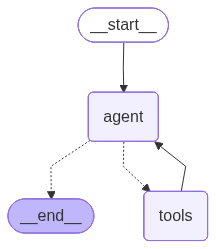

In [28]:
react_agent = create_simple_agent()

from IPython.display import Image, display


display(Image(react_agent.get_graph().draw_mermaid_png()))



- LangGraph에서 구현한 ReAct Agent는 아래와 같은 모습을 하고 있습니다.
    - "agent"라고 붙은 LLM **노드** 에서 사용자의 질의를 처리합니다.
        - agent 노드에서는 \_\_end\_\_ 노드와 tools 노드 방향으로 향하는 점선의 edge가 있습니다. 이 edge가 바로 conditional edge 입니다.
            - tools 활용이 필요하면 tools로, 그렇지 않고 답변을 마칠 수 있으면 \_\_end\_\_로 갈 수 있게 돼있습니다.  

이제 이 ReAct Agent에 질의를 한번 해보겠습니다. 

(우선 간단하게 메모리 관리를 위해 LangGraph의 `InMemorySaver`를 설정하고 `config`를 설정해줬습니다.)


In [32]:
config = {"configurable": {"thread_id": "1"}}
response = react_agent.invoke(
    {"messages": [{"role": "user", "content": "우리 회사 API에 접속이 잘 안되는데."}]},
    config  
)
print(response['messages'])

Search with the query: 회사 API 접속 문제 해결 방법
[HumanMessage(content='우리 회사 API에 접속이 잘 안되는데.', additional_kwargs={}, response_metadata={}, id='849d77a9-c9ba-49a6-88bc-290cb87a6582'), AIMessage(content='[API 접속 문제를 해결하기 위해 내부 지식 베이스에서 관련 해결 방법을 검색하고, 추가로 웹에서 최신 정보를 확인하기 위해 두 함수를 호출했습니다. 내부 지식 베이스에는 회사 특정 API 문제 해결 절차가 있을 수 있으며, 웹 검색은 일반적인 API 접속 문제 해결 방법을 제공할 수 있어 둘 다 필수적입니다.]  \n\n추가로 다음 정보를 제공해 주시면 더 정확한 도움을 드릴 수 있습니다:  \n1. 어떤 API 엔드포인트에 접속하시려고 하나요?  \n2. 어떤 오류 메시지가 표시되나요? (예: 404 Not Found, 500 Internal Server Error 등)  \n3. 접속 시도 시 사용한 클라이언트/도구(Postman, cURL 등)와 요청 예시(헤더/바디 포함)가 있나요?', additional_kwargs={'tool_calls': [{'id': 'chatcmpl-tool-f9ff751235ea444383300e284ff0bb90', 'function': {'arguments': '{"query": "\\ud68c\\uc0ac API \\uc811\\uc18d \\ubb38\\uc81c \\ud574\\uacb0 \\ubc29\\ubc95"}', 'name': 'search_knowledge_base'}, 'type': 'function'}, {'id': 'chatcmpl-tool-5c753ae623c14a519ec47067eaf7f0a1', 'function': {'arguments': '{"query": "\\ud68c\\uc0ac API \\uc811\\uc18d \\ubb38\\uc8

In [35]:
## 결과 확인을 위한 Helper Function 입니다. ##
def pretty_print_conversation(messages):
    """Pretty print conversation flow with detailed step-by-step analysis."""
    
    print("\n" + "="*80)
    print("�� CONVERSATION FLOW ANALYSIS")
    print("="*80)
    
    step_counter = 1
    
    for i, message in enumerate(messages):
        print(f"\n{'─'*60}")
        print(f"📝 STEP {step_counter}: {message.__class__.__name__}")
        print(f"{'─'*60}")
        
        if isinstance(message, HumanMessage):
            print(f"👤 USER INPUT:")
            print(f"   {message.content}")
            
        elif isinstance(message, AIMessage):
            if hasattr(message, 'tool_calls') and message.tool_calls:
                print(f"🤖 ASSISTANT DECISION:")
                print(f"   💭 Reasoning: {message.content}")
                print(f"\n🔧 TOOL CALLS:")
                
                for j, tool_call in enumerate(message.tool_calls):
                    print(f"   {j+1}. Tool: {tool_call['name']}")
                    print(f"      Args: {tool_call['args']}")
                    print(f"      ID: {tool_call['id']}")
            else:
                print(f"🤖 ASSISTANT RESPONSE:")
                print(f"   {message.content}")
                
        elif hasattr(message, 'name') and message.name:  # ToolMessage
            print(f"📚 TOOL EXECUTION RESULT:")
            print(f"   Tool: {message.name}")
            print(f"   Call ID: {message.tool_call_id}")
            print(f"   Result:")
            print(f"   {message.content}")
            
        # Show metadata if available
        if hasattr(message, 'response_metadata') and message.response_metadata:
            metadata = message.response_metadata
            if 'token_usage' in metadata:
                tokens = metadata['token_usage']
                print(f"\n�� TOKEN USAGE:")
                print(f"   Input: {tokens.get('prompt_tokens', 0)}")
                print(f"   Output: {tokens.get('completion_tokens', 0)}")
                print(f"   Total: {tokens.get('total_tokens', 0)}")
        
        step_counter += 1
    
    print(f"\n{'='*80}")
    print("✅ CONVERSATION ANALYSIS COMPLETE")
    print("="*80)


def analyze_tool_usage(messages):
    """Analyze tool usage patterns in the conversation."""
    
    print("\n" + "="*60)
    print("🔍 TOOL USAGE ANALYSIS")
    print("="*60)
    
    tool_calls = []
    tool_results = []
    
    for message in messages:
        if isinstance(message, AIMessage) and hasattr(message, 'tool_calls') and message.tool_calls:
            for tool_call in message.tool_calls:
                tool_calls.append({
                    'name': tool_call['name'],
                    'args': tool_call['args'],
                    'reasoning': message.content
                })
        elif hasattr(message, 'name') and message.name:
            tool_results.append({
                'name': message.name,
                'result': message.content,
                'call_id': message.tool_call_id
            })
    
    print(f"\n📊 SUMMARY:")
    print(f"   Total Tool Calls: {len(tool_calls)}")
    print(f"   Total Tool Results: {len(tool_results)}")
    
    if tool_calls:
        print(f"\n🔧 TOOL CALLS BREAKDOWN:")
        for i, call in enumerate(tool_calls, 1):
            print(f"   {i}. {call['name']}")
            print(f"      Arguments: {call['args']}")
            print(f"      Reasoning: {call['reasoning'][:100]}...")
    
    if tool_results:
        print(f"\n�� TOOL RESULTS BREAKDOWN:")
        for i, result in enumerate(tool_results, 1):
            print(f"   {i}. {result['name']}")
            print(f"      Result Length: {len(result['result'])} characters")
            print(f"      Preview: {result['result'][:100]}...")


아래 결과를 통해 대화의 흐름을 살펴보도록 하겠습니다.

In [37]:
pretty_print_conversation(response['messages'])

# Analyze tool usage
analyze_tool_usage(response['messages'])


�� CONVERSATION FLOW ANALYSIS

────────────────────────────────────────────────────────────
📝 STEP 1: HumanMessage
────────────────────────────────────────────────────────────
👤 USER INPUT:
   우리 회사 API에 접속이 잘 안되는데.

────────────────────────────────────────────────────────────
📝 STEP 2: AIMessage
────────────────────────────────────────────────────────────
🤖 ASSISTANT DECISION:
   💭 Reasoning: [API 접속 문제를 해결하기 위해 내부 지식 베이스에서 관련 해결 방법을 검색하고, 추가로 웹에서 최신 정보를 확인하기 위해 두 함수를 호출했습니다. 내부 지식 베이스에는 회사 특정 API 문제 해결 절차가 있을 수 있으며, 웹 검색은 일반적인 API 접속 문제 해결 방법을 제공할 수 있어 둘 다 필수적입니다.]  

추가로 다음 정보를 제공해 주시면 더 정확한 도움을 드릴 수 있습니다:  
1. 어떤 API 엔드포인트에 접속하시려고 하나요?  
2. 어떤 오류 메시지가 표시되나요? (예: 404 Not Found, 500 Internal Server Error 등)  
3. 접속 시도 시 사용한 클라이언트/도구(Postman, cURL 등)와 요청 예시(헤더/바디 포함)가 있나요?

🔧 TOOL CALLS:
   1. Tool: search_knowledge_base
      Args: {'query': '회사 API 접속 문제 해결 방법'}
      ID: chatcmpl-tool-f9ff751235ea444383300e284ff0bb90
   2. Tool: web_search
      Args: {'query': '회사 API 접속 문제 해결 방법

대화의 내용을 살펴보면,

> '`search_knowledge_base`는 회사 내부 기술 문서에서 공식 해결 방법을 찾기 위해, `web_search`는 일반적인 API 접속 문제 해결 방법을 보완하기 위해 호출~'

이라고 LLM이 Reasoning하는 부분을 확인할 수 있습니다.

LLM의 tool calling은 경우에 따라 다양한 방식으로 활용되기도 하고, 특정 방향으로 컨트롤 하는 것이 간단하지는 않습니다. 저희가 Prompt Enigneering을 통해 LLM의 작동방식을 통제하듯이, Tool Calling의 경우에도

Tool의 이름, Tool의 상세설명을 더 자세하고 상세하게 다는 것으로 확인 할 수 있습니다. 

- Tool의 이름을 잘 짓는 것이 중요한 이유: [링크](https://slashpage.com/sujin-prompt-engineer/prompt_tips?post=d367nxm3qz86jmj98pv1)

## 5.3 ReAct Agent 직접 만들어보기



따라서 다음과 같은 과정을 거치면 ReAct Agent를 직접 만들어볼 수도 있습니다.

1. `AgentState`를 선언해줍니다. 이 State는 Agent의 정보들을 기록하는 곳입니다. 간단하게 대화의 내용만 기록하도록 하겠습니다.

2. `llm_node`를 생성합니다.
    - 이 때 모델은 선언하고, 기존의 정의된 tool들을 사용할 수 있게, `model.bind_tools(tools)`을 해줍니다.

3.  `tool_node`를 생성합니다.
    - 모델이 tool calling을 할 때, 메세지에 담겨있는 "name"과 "args"를 확인해 tool을 실제로 실행하는 함수입니다.

이번에는 노드를 실제로 구현해보겠습니다.

- LangGraph에서 노드는 실제로 작업이 일어나는 곳으로, 간단하게 Python 함수로 구현돼있습니다.

    - 이 때, 함수는 Graph의 State를 입력으로 받고, 내부적으로 State를 업데이트 한 다음 반환하는 형태입니다.

### 5.3.1 AgentState 정의하기

In [39]:
class AgentState(TypedDict):
    """The state of the agent."""
    messages: Annotated[Sequence[BaseMessage], add_messages]

### 5.3.2 LLM 노드 정의하기

In [42]:
model = ChatUpstage(model="solar-pro2", temperature=0)
tools = [search_knowledge_base, web_search]
model = model.bind_tools(tools)

def llm_node(state: AgentState) -> Dict[str, Any]:
    system = SystemMessage(
        "You are Agent, a concise and helpful support assistant. "
        "Answer using only provided info and be kind."
    )
    resp = model.invoke([system] + state["messages"])
    return {"messages": [resp]}

### 5.3.3 Tool 노드 정의하기

In [44]:
tools_by_name = {tool.name: tool for tool in tools}

def tool_node(state: AgentState):
    outputs = []
    for tool_call in state["messages"][-1].tool_calls:
        tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])
        outputs.append(
            ToolMessage(
                content=json.dumps(tool_result),
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    return {"messages": outputs}


In [45]:
message = AIMessage(
    content="",
    tool_calls=[{
        "name": "search_knowledge_base",
        "args": {"query": 'How can I reset my password?', "top_k": 3},
        "id": "tool_call_id",
        "type": "tool_call"
    }]
)
response = tool_node(state={"messages": [message]})
print(response['messages'][0].content)

[{"content": "To reset your password, go to the login page and click 'Forgot Password'. Enter your email address and check your inbox for reset instructions. The reset link expires in 24 hours.", "score": 0.5518820285797119, "topic": "Password Reset", "category": "Account", "index": 0, "rank": 1}, {"content": "Two-factor authentication (2FA) can be enabled in Security Settings. We support SMS, email, and authenticator apps. 2FA is required for Enterprise accounts and recommended for all users.", "score": 0.3110274374485016, "topic": "Security", "category": "Account", "index": 5, "rank": 2}, {"content": "Data export is available for all plans. Go to Account Settings > Data Export to request your data. The export will be emailed to you within 24 hours and includes all your account data in JSON format.", "score": 0.2634652853012085, "topic": "Data Export", "category": "Account", "index": 4, "rank": 3}]


이제 ReAct 구조에 핵심이라고 할 수 있는 LLM에서 tools와 \_\_end\_\_를 조건부(conditional)연결하는 로직을 작성해보겠습니다.

### 5.3.4 Conditional Edge 정의하기

`Conditional Edge`는 현재 그래프의 상태 (`state`)를 입력으로 받아 다음에 어느 것으로 향할 지 알려주는 Python 함수입니다.

`tool_calling`을 할 지, 답변을 생성할 지에 대해서는 다음과 같은 로직으로 확인이 가능합니다:

1. state에 담고있는 `messages`를 가장 최근 메세지를 확인했을 때, tool_calls 가 있으면 tool calling
2. 그렇지 않으면 "end"로!

위의 로직을 다음과 같이 구현해보겠습니다.

In [46]:
def tool_call_or_end(state: AgentState):

    messages = state["messages"]
    last_message = messages[-1]
    
    if not last_message.tool_calls:
        return "end"
    else:
        return "tool_call_needed"


이제 이 Conditional Edge와 함께 그래프를 만들어보겠습니다.

### 5.3.5 ReAct 그래프 빌드하기

In [48]:
builder = StateGraph(AgentState)
builder.add_node("llm", llm_node) # Node를 더할 때는 "노드의 이름", 함수 형태로 선언합니다.
builder.add_node("tools", tool_node)
builder.set_entry_point("llm")


builder.add_conditional_edges(
    # 시작점을 "llm" 으로 선정해줍니다.
    "llm",
    # 분기 조건에 해당하는 함수를 넣어줍니다.
    tool_call_or_end,
    # 마지막으로 return 되는 값에 따라 어디로 향할 지를 정해줍니다.
    # "end"인 경우 그래프를 종료하는 곳으로
    # "tool_call_needed"인 경우 "tools"로 향하게 됩니다.
    {
        # If `tools`, then we call the tool node.
        "tool_call_needed": "tools",
        # Otherwise we finish.
        "end": END,
    },
)

# tools 노드에서 나온 결과는 다시 llm 노드로 향하게 됩니다.
builder.add_edge("tools", "llm")


graph = builder.compile()


from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))


ValueError: Failed to reach https://mermaid.ink/ API while trying to render your graph. Status code: 502.

To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`

In [49]:
for chunk in graph.stream(
    {"messages": [("human", "How can I reset my password?")]},
    stream_mode="values",
):
    # 마지막 메시지 출력
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

How can I reset my password?
================================== Ai Message ==================================

To reset your password, you can typically follow these general steps (no function calls needed as this is standard procedure):

1. Go to the login page of the service you're using
2. Click "Forgot Password" or similar link
3. Enter your registered email address
4. Check your email for a password reset link
5. Click the link and follow instructions to create a new password

If you need specific instructions for a particular service, please let me know which one you're referring to, and I can provide more detailed guidance. 

No function calls are needed since this is general knowledge about password reset processes.


## 5.4 Build Comprehensive Workflow

- 지금까지는 간단하게 ReAct Agent로 고객 응대 하는 에이전트를 만들어봤습니다.
- 이 에이전트를 더 개선된 형태로 만드려면 어떤 방법이 있을까요?
    - 우선 현재는 State에 대화내용만 기록하고 있습니다. 이런 구조보다는 State에 고객의 id, 고객의 정보, 고객의 질문을 따로 관리하는 것이 더 좋을 수 있습니다.
    
    - 또한 Tool을 사용했을 때의 결과도 따로 저장을 해두면, 특정 분기를 하는 과정에서 요긴하게 쓸 수도 있습니다. 예를 들어, 문서 검색을 해서 정보는 가져왔지만 유사도가 많이 낮다면 다른 분기를 할 수도 있습니다.

    - 에이전트의 형태 자체도 새로 생각할 수 있습니다.
        - 유저의 정보와 질문을 `llm` 노드로 향하기 전에 미리 입력을 받을 수 있습니다.
        - `llm`이 `tools`에서 답변을 받은 뒤 답변을 생성하기 전에 **한번의 분기**를 추가하여
            - 이 `tools`에서 받은 결과가 얼마나 **효과적인지** 판단한 후에
                1. 효과적이지 않다면, 담당자에게 전달하거나
                2. 효과적이라면, 답변을 생성하고 마칠 수 있습니다.

이런 식으로 에이전트를 구성하는 것은 실제 업무의 흐름에 해당하는 Workflow를 상세하게 구현하고 해당 로직을 정교하게 설계하는 일이라고 볼 수 있습니다.

1. 우선 위에서 tool을 만들었던 방식과 동일하게 `fetch_customer_data` tool을 만들어보겠습니다.
    - 이번 실습에서는 위에서 구현한 `load_customer_data`를 통해 데모 데이터 (`csv`)를 딕셔너리 형태로 변환해서 데이터 형태로 가지고 있습니다!

### 5.4.1 GraphState 정의하기


우선 위에서 생각해 본 워크플로우를 토대로 Agent가 들고 갈 정보를 다음과 같이 추릴 수 있습니다.
- customer_question: str
    - 사용자의 질문을 str 형태로 저장합니다.
- customer_id: str
    - 사용자의 id를 str 형태로 저장합니다.
- customer_context: str
    - 사용자의 정보를 str 형태로 저장합니다.
- knowledge_base_results: List[Dict[str, Any]]
    - knowledge_base_search의 결과를 딕셔너리가 담긴 리스트 형태로 저장합니다.
- web_search_raw_results: List[Dict[str, Any]]
    - web_search의 결과를 딕셔너리가 담긴 리스트 형태로 저장합니다.
- specialist_info: Dict[str, Any]
    - 담당자(specialist)의 정보를 딕셔너리로 저장합니다.
- messages: Annotated[List[BaseMessage], add_messages]
    - messages를 기록하고 langgraph의 `add_messages` Reducer를 사용해 자동으로 리스트에 추가되도록 저장합니다.

위의 정보들을 기록하는 GraphState를 우선 만들어보겠습니다.

In [51]:
class GraphState(TypedDict):
    customer_question: str
    customer_id: str
    customer_context: str
    knowledge_base_results: List[Dict[str, Any]]
    web_search_raw_results: List[Dict[str, Any]] 
    specialist_info: Dict[str, Any]
    messages: Annotated[List[BaseMessage], add_messages]

### 5.4.2 get_customer_id, get_customer_question 정의하기

- GraphState에서 고객의 id, 고객의 정보, 고객의 질문을 따로 관리하기로 했습니다. 

- 이 부분은 사용자에게 직접 id를 입력받아 정보를 가져오고, 그 다음 질문을 입력받아 질문을 관리하는 로직으로 생각해보겠습니다.

    - 실제로 서비스를 할 때는 사용자가 이미 로그인을 한 상태라면 그 때의 정보를 가지고 오도록 활용할 수도 있습니다!

In [55]:
# Section1에서 정의한 customers
print(customers)

{'CUST001': {'customer_id': 'CUST001', 'name': '김민준', 'email': 'kim.minjun@email.com', 'plan': 'Premium', 'subscription_status': 'active', 'last_login': '2024-01-15', 'account_age_days': 365, 'previous_issues': 2}, 'CUST002': {'customer_id': 'CUST002', 'name': '이서연', 'email': 'lee.seoyeon@company.com', 'plan': 'Basic', 'subscription_status': 'active', 'last_login': '2024-01-14', 'account_age_days': 180, 'previous_issues': 0}, 'CUST003': {'customer_id': 'CUST003', 'name': '박지훈', 'email': 'park.jihoon@tech.com', 'plan': 'Enterprise', 'subscription_status': 'active', 'last_login': '2024-01-13', 'account_age_days': 730, 'previous_issues': 5}, 'CUST004': {'customer_id': 'CUST004', 'name': '최수빈', 'email': 'choi.subin@startup.io', 'plan': 'Premium', 'subscription_status': 'expired', 'last_login': '2024-01-10', 'account_age_days': 90, 'previous_issues': 1}, 'CUST005': {'customer_id': 'CUST005', 'name': '정하은', 'email': 'jung.haeun@corp.com', 'plan': 'Basic', 'subscription_status': 'active', 'la

In [56]:
def fetch_customer_data(customer_id: str) -> str:
    """Fetch customer data from CRM system."""
    try:
        customer_data = customers.get(customer_id, {})
        
        if not customer_data:
            return "No customer data found for this ID."
        
        context_parts = []
        if customer_data.get('name'):
            context_parts.append(f"Name: {customer_data['name']}")
        if customer_data.get('email'):
            context_parts.append(f"Email: {customer_data['email']}")
        if customer_data.get('plan'):
            context_parts.append(f"Plan: {customer_data['plan']}")
        if customer_data.get('subscription_status'):
            context_parts.append(f"Status: {customer_data['subscription_status']}")
        if customer_data.get('account_age_days'):
            context_parts.append(f"Account Age: {customer_data['account_age_days']} days")
        if customer_data.get('previous_issues'):
            context_parts.append(f"Previous Issues: {customer_data['previous_issues']}")
        
        customer_context = "Customer Information:\n" + "\n".join(context_parts)
        # print(f"✅ Customer context retrieved for {customer_id}")
        return customer_context
        
    except Exception as e:
        return f"❌ Customer data fetch error: {str(e)}"

In [57]:
print(fetch_customer_data("CUST001"))

Customer Information:
Name: 김민준
Email: kim.minjun@email.com
Plan: Premium
Status: active
Account Age: 365 days
Previous Issues: 2


위 함수를 바탕으로 두 노드, `get_customer_id`와 `get_customer_question`를 만들어보겠습니다.

이 때는 langgraph의 `interrupt`를 활용해보겠습니다. `interrupt`는 말 그대로 사용자가 개입해 특정 액션을 하도록 입력을 주는 것으로 Python에서의 `input()`과 비슷한 역할이라고 볼 수 있습니다.

In [ ]:
def get_customer_id(state: GraphState) -> Dict[str, Any]:
    """Get customer ID from user."""
    customer_id = interrupt("🆔 Welcome to Customer Support! Can you please enter your Customer ID (CUSTXXX format)?") # 사용자에게 Customer ID를 입력받습니다.
    
    # Validate customer ID format
    if not customer_id or not customer_id.startswith("CUST"):
        customer_id = interrupt(f"❌ Invalid format '{customer_id}'. Please enter your Customer ID in CUSTXXX format:")
    
    customer_context = fetch_customer_data(customer_id)
    print(f"✅ Customer context retrieved for {customer_id}")
    print(f"✅ Customer context: {customer_context}")
    return {"customer_id": customer_id, "customer_context": customer_context}

def get_customer_question(state: GraphState) -> Dict[str, Any]:
    """Get customer question from user."""
    customer_question = interrupt("❓ Do you need any help? Please describe your issue or question:") # 사용자에게 질문을 입력받습니다.
    
    if not customer_question or len(customer_question.strip()) < 5:
        customer_question = interrupt("❓ Please provide more details about your issue:")
    
    return {"customer_question": customer_question}

** 위에서 간단하게 구현한 get_customer_id에 멀티턴이 가능하도록 다양한 로직을 추가해보겠습니다.**

- 실제 서비스와는 다를 수 있지만 다음의 경우들을 처리해보겠습니다.


* 1. 고객 ID 형식 검증 (`if not customer_id ...`)
    * 에러 메시지와 함께 재입력을 요청.

* 2. 대화 상태 관리 (`if/elif/else`)
    1. `if ...` (이전 고객과 ID가 다른 경우)
        * 다른 고객이므로, 이전 대화 기록(검색 결과, 질문 등)을 **전부 초기화**.
    2. `elif ...` (이전 고객 ID가 없는 새로운 세션)
        * 첫 대화이므로, 모든 상태 변수를 **깨끗하게 초기화**.
    3. `else` (이전 고객과 ID가 같은 경우)
        * 동일 고객의 새 질문으로 간주하고, 고객 정보는 유지하되 **이전 검색 결과만 초기화**.

In [59]:

def get_customer_id(state: GraphState) -> Dict[str, Any]:
    """Get customer ID from user."""
    customer_id = interrupt("🆔 Welcome to Customer Support! Can you please enter your Customer ID (CUSTXXX format)?")
    
    # Validate customer ID format
    if not customer_id or not customer_id.startswith("CUST"):
        customer_id = interrupt(f"❌ Invalid format '{customer_id}'. Please enter your Customer ID in CUSTXXX format:")
    
    # Check if customer has changed - if so, reset search results
    previous_customer_id = state.get("customer_id", "")
    update_dict = {"customer_id": customer_id}
    
    if previous_customer_id and previous_customer_id != customer_id:
        print(f"🔄 Customer changed from {previous_customer_id} to {customer_id} - resetting search results")
        update_dict.update({
            "knowledge_base_results": [],
            "web_search_raw_results": [],
            "specialist_info": {},
            "customer_question": ""  # Reset previous question too
        })
    elif not previous_customer_id:
        print(f"🆕 New session for customer {customer_id}")
        # Initialize empty results for new session
        update_dict.update({
            "knowledge_base_results": [],
            "web_search_raw_results": [],
            "specialist_info": {},
            "customer_question": ""
        })
    else:
        print(f"🔄 Same customer {customer_id} - keeping existing context but resetting search results for new question")
        # Even for same customer, reset search results for new question
        update_dict.update({
            "knowledge_base_results": [],
            "web_search_raw_results": [],
            "specialist_info": {},
            "customer_question": ""
        })
    
    # Fetch customer context
    customer_context = fetch_customer_data(customer_id)
    update_dict["customer_context"] = customer_context
    
    print(f"✅ Customer context retrieved for {customer_id}")
    print(f"✅ Customer context: {customer_context}")
    
    return update_dict

### 5.4.3 tool_node 정의하기


tool_node를 먼저 정의해보겠습니다. GraphState에서 정의한대로 `knowledge_base_results`와 `web_search_raw_results`를 각각 툴을 사용할 때마다 업데이트 해줄 예정이기 때문에

tool_node를 구현할 때 해당 로직도 함께 넣어주겠습니다.

In [60]:
tools = [search_knowledge_base, web_search]

tools_by_name = {tool.name: tool for tool in tools}

def tool_node(state: GraphState) -> Dict[str, Any]:
    """Execute tools and update state with structured results."""
    
    outputs = []
    update = {"messages": []}
    
    for tool_call in state["messages"][-1].tool_calls:
        tool_result = None
        for tool in tools:
            if tool.name == tool_call["name"]:
                tool_result = tool.invoke(tool_call["args"])
                break
        
        outputs.append(
            ToolMessage(
                content=json.dumps(tool_result) if tool_result else "Tool not found",
                tool_call_id=tool_call["id"],
            )
        )
        
        if tool_call["name"] == "search_knowledge_base": # tool_call이 search_knowledge_base인 경우
            kb_results = tool_result if isinstance(tool_result, list) else []
            update["knowledge_base_results"] = kb_results # knowledge_base_results를 업데이트 해줍니다.
            print(f"📚 KB search completed with {len(kb_results)} results")
        
        if tool_call["name"] == "web_search": # tool_call이 web_search인 경우
            web_results = tool_result if isinstance(tool_result, list) else []
            update["web_search_raw_results"] = web_results # web_search_raw_results를 업데이트 해줍니다.
            print(f"🌐 Web search completed with {len(web_results)} results")
    
    update["messages"] = outputs # 위에서 정의한 outputs를 업데이트 해줍니다.
    return update

### 5.4.4 LLM 노드 정의하기

위에서 간단하게 이전 message를 보면서 대답하는 형태와 달리, 이번엔 저장돼있는 컨텍스트를 활용해 llm_node를 구현해보겠습니다.

1. 우선 `customer_id`와 `customer_question`을 State에서 가져옵니다.
    - 이를 통해 customer에 대한 정보, `customer_context`를 얻을 수 있습니다.
2. LLM의 작동방식을 두 가지로 나누겠습니다.
    1. 우선 가장 처음 LLM이 작동할 때는 유저의 Id, 정보 그리고 활용할 수 있는 툴의 정보를 바탕으로 판단을 합니다.
    2. 만약 `tool_node`에서 툴에 대한 결과를 받아 온 경우, 이 tool_node에서 업데이트 된 context를 바탕으로 답변을 합니다.

복잡해보이지만 두 가지 경우로 나눈 뒤, 각각 필요한 값을 state에서 가져와 prompt에 넣어주는 간단한 방식으로 구현할 수 있습니다.

In [61]:
builder = StateGraph(GraphState)
model = ChatUpstage(model="solar-pro2", temperature=0)
model_with_tools = model.bind_tools(tools)


def llm_node(state: GraphState) -> Dict[str, Any]:
    """Main LLM node that processes customer requests and calls tools."""
    customer_id = state.get("customer_id", "Unknown")
    customer_question = state.get("customer_question", "")
            
        # Get customer context
    customer_context = state.get("customer_context", "No customer context available")
    
    print(f"🤖 Processing question for {customer_id}: {customer_question[:100]}...")
    
    # Check if we have tool results by looking at state fields directly
    kb_results = state.get("knowledge_base_results", [])
    web_results = state.get("web_search_raw_results", [])
    has_tool_results = len(kb_results) > 0 or len(web_results) > 0
    
    if has_tool_results:
        print("We have tool results")

        
        # Format knowledge base results
        kb_context = ""
        if kb_results:
            kb_formatted = []
            for result in kb_results:
                if isinstance(result, dict) and 'content' in result:
                    topic = result.get('topic', 'Unknown')
                    category = result.get('category', 'Unknown')
                    content = result.get('content', '')
                    score = result.get('score', 0.0)
                    kb_formatted.append(f"- [{category} - {topic}] (Score: {score:.1%}): {content}")
            kb_context = "\n".join(kb_formatted)
        
        # Format web search results
        web_context = ""
        if web_results:
            web_formatted = []
            for result in web_results:
                if isinstance(result, dict) and 'content' in result:
                    title = result.get('title', 'Untitled')
                    content = result.get('content', '')
                    url = result.get('url', '')
                    score = result.get('score', 0.0)
                    web_formatted.append(f"- [{title}] (Score: {score:.1%}): {content}\n  Source: {url}")
            web_context = "\n".join(web_formatted)
        
        # Construct comprehensive system prompt with all context
        system_prompt = f"""You are a Customer Service Assistant helping customer {customer_id}.

CUSTOMER CONTEXT:
{customer_context}

AVAILABLE INFORMATION:"""
        
        if kb_context:
            system_prompt += f"""

KNOWLEDGE BASE RESULTS:
{kb_context}"""
        
        if web_context:
            system_prompt += f"""

WEB SEARCH RESULTS:
{web_context}"""
        
        system_prompt += f"""

CUSTOMER QUESTION: {customer_question}

INSTRUCTIONS:
Use the above information to provide a comprehensive, helpful answer to the customer's question. 
Reference the relevant information from the search results and consider the customer's context.
Be specific and cite the sources when appropriate.
Do NOT call any tools - provide your final answer based on the available information."""

        system = SystemMessage(system_prompt)
        
    else:
        print("First pass: LLM decides whether to use tools or answer directly")
        # First pass: LLM decides whether to use tools or answer directly
        system = SystemMessage(
            f"You are a Customer Service Assistant helping customer {customer_id}.\n"
            f"Customer context: {customer_context}\n"
            f"Available tools: search_knowledge_base, web_search.\n\n"
            f"Customer question: '{customer_question}'\n\n"
            f"Instructions:\n"
            f"1. If you can fully answer this question with your knowledge, provide a complete, helpful response.\n"
            f"2. If you need specific information, call the appropriate tools to gather information.\n"
            f"3. If you cannot help or the request is beyond your capabilities, clearly state: 'I cannot help with this and need to escalate this to a specialist.'"
        )
    
    print(f"🔧 System message: {system.content[:200]}...")
    print(f"📊 Tool results available: KB={len(kb_results)}, Web={len(web_results)}")
    
    # For tool results case, we have all context in system prompt, so just pass customer question
    # For first pass, we need the model to potentially call tools
    response = model_with_tools.invoke([system, HumanMessage(content=customer_question)])
    
    return {
        "messages": [response]
    }

### 5.4.5 Conditional Edge 정의하기

분기 처리를 위해 `tools_condition` 을 정의해보겠습니다.
이전에 두 곳으로 나뉘었던 것과 달리 이번에는 세 곳의 노드로 향하는 `tools_condition`을 구현하겠습니다.

1. "tools": 도구 사용이 필요할 때

2. "end": 답변을 낼 수 있을 때

3. "escalate_to_specialist": 전문가의 도움이 필요할 때
    - Tool을 사용했을 때의 스코어로 검증합니다!


In [62]:
def tools_condition(state: GraphState) -> Literal["tools", "end", "escalate_to_specialist"]:
    last_message = state["messages"][-1]
    
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        print("🔄 LLM wants to use tools")
        return "tools"
    else:
        # Check if we have tool results and their quality
        kb_results = state.get("knowledge_base_results", [])
        web_results = state.get("web_search_raw_results", [])
        
        # Calculate scores from tool results
        kb_scores = [r.get('score', 0.0) for r in kb_results if isinstance(r, dict) and 'score' in r]
        web_scores = [r.get('score', 0.0) for r in web_results if isinstance(r, dict) and 'score' in r]
        
        max_kb_score = max(kb_scores) if kb_scores else 0.0
        max_web_score = max(web_scores) if web_scores else 0.0
        
        print(f"📊 Tool result quality: KB={max_kb_score:.1%}, Web={max_web_score:.1%}")
        

        
        has_good_kb = max_kb_score >= 0.25  # 25% threshold for KB
        has_good_web = max_web_score >= 0.5  # 50% threshold for Web
        has_any_tools_used = len(kb_results) > 0 or len(web_results) > 0
        has_sufficient_info = has_good_kb or has_good_web
        
        if has_any_tools_used and not has_sufficient_info:
            print("🔄 Tool results have low similarity scores - escalating")
            return "escalate_to_specialist"
        else:
            print("🔄 LLM provided final answer - ending conversation")
            return "end"

### 5.4.6 `escalate_to_specialist` 노드 만들기

`escalate_to_specialist`는 
1. 사용자의 질문을 분류하고 적절한 담당자를 찾아서 전달합니다.
    - 이 때 state를 업데이트 합니다.
2. 사용자에게 담당자에게 전달됐다는 메세지를 작성합니다.
    - 실제로는 담당자에게 알림을 보내는 별도의 tool을 구현할 수도 있습니다.

In [63]:
class InquiryCategorySchema(BaseModel):
    category: Literal["Technical", "Billing", "Account", "General", "Urgent"]

def classify_inquiry(customer_question: str) -> str:
    """Use LLM with structured output to classify customer inquiry."""
    llm = ChatUpstage(model="solar-pro2", temperature=0)
    llm_structured = llm.with_structured_output(InquiryCategorySchema)
    
    classification_prompt = f"""
    Classify the following customer inquiry into one of these categories:
    - Technical: Issues related to API, software, technical problems, bugs, system errors
    - Billing: Payment issues, subscription problems, billing questions, refunds
    - Account: Account management, login issues, password reset, profile changes
    - General: General questions, information requests, non-specific inquiries
    - Urgent: Critical issues requiring immediate attention, system outages, security breaches
    
    Customer Question: "{customer_question}"
    
    Classify this inquiry into the most appropriate category.
    """
    
    result = llm_structured.invoke(classification_prompt)
    return result.category

In [64]:
def escalate_to_specialist(state: GraphState) -> Dict[str, Any]:
    """Classify inquiry, assign specialist, and notify customer."""
    print("🚨 Escalating to specialist")
    
    customer_question = state.get("customer_question", "")
    
    # Classify inquiry for specialist assignment
    inquiry_category = classify_inquiry(customer_question)
    specialist_info = specialists.get(inquiry_category, specialists["General"])
    
    print(f"🏷️ Classified as: {inquiry_category}")
    print(f"📋 Escalating to: {specialist_info['specialist']}")
    
    # Simulate sending to specialist
    print(f"   ✉️ Escalation sent to {specialist_info.get('email', 'unknown')}")
    
    # Generate customer notification
    escalation_message = HumanMessage(
        content=f"I apologize, but I wasn't able to find sufficient information to help you with your inquiry. "
                f"I'm escalating your case to our specialist team.\n\n"
                f"🏷️ **Assigned Specialist**: {specialist_info.get('specialist', 'Unknown')}\n"
                f"📧 **Email**: {specialist_info.get('email', 'Unknown')}\n"
                f"🎯 **Expertise**: {', '.join(specialist_info.get('expertise', ['General Support']))}\n"
                f"⏱️ **Expected Response Time**: {specialist_info.get('response_time', 'Unknown')}\n\n"
                f"They will have access to more resources and will be able to provide you with a comprehensive solution. "
                f"Thank you for your patience!"
    )
    
    return {
        "specialist_info": specialist_info,
        "messages": [escalation_message]
    }

### 5.4.7 Agent 빌드하기

In [65]:
builder = StateGraph(GraphState)

# Add nodes
builder.add_node("get_customer_id", get_customer_id)
builder.add_node("get_customer_question", get_customer_question)
builder.add_node("llm", llm_node)
builder.add_node("tools", tool_node)
builder.add_node("escalate_to_specialist", escalate_to_specialist)

# Simple linear flow with conditional edges
builder.set_entry_point("get_customer_id")
builder.add_edge("get_customer_id", "get_customer_question")
builder.add_edge("get_customer_question", "llm")

# ReAct-style routing from LLM
builder.add_conditional_edges("llm", tools_condition, {
    "tools": "tools",
    "end": END,
    "escalate_to_specialist": "escalate_to_specialist"
})

# After tools, LLM generates final answer (no loop)
builder.add_edge("tools", "llm")

# Escalation path
builder.add_edge("escalate_to_specialist", END)

from langgraph.checkpoint.memory import InMemorySaver
checkpointer = InMemorySaver()
graph = builder.compile(checkpointer=checkpointer)

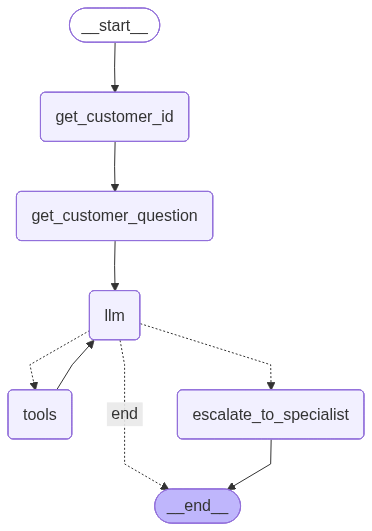

In [66]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [67]:
config = {"configurable": {"thread_id": "1"}}
for event in graph.stream(
    {"messages": [("human", "")]},
    stream_mode="updates",
    config=config,
):
    print(event)

{'__interrupt__': (Interrupt(value='🆔 Welcome to Customer Support! Can you please enter your Customer ID (CUSTXXX format)?', id='83944f026107abbb19c9165d21e9f18d'),)}


In [68]:
from langgraph.types import Command
for event in graph.stream(
    Command(resume="CUST001"),
    stream_mode="updates",
    config=config,
):
    print(event)
    print("\n")

🆕 New session for customer CUST001
✅ Customer context retrieved for CUST001
✅ Customer context: Customer Information:
Name: 김민준
Email: kim.minjun@email.com
Plan: Premium
Status: active
Account Age: 365 days
Previous Issues: 2
{'get_customer_id': {'customer_id': 'CUST001', 'knowledge_base_results': [], 'web_search_raw_results': [], 'specialist_info': {}, 'customer_question': '', 'customer_context': 'Customer Information:\nName: 김민준\nEmail: kim.minjun@email.com\nPlan: Premium\nStatus: active\nAccount Age: 365 days\nPrevious Issues: 2'}}


{'__interrupt__': (Interrupt(value='❓ Do you need any help? Please describe your issue or question:', id='d96659bf6b8f8f14585e231fb7be2145'),)}




In [69]:
for event in graph.stream(
    Command(resume="How do I reset my password? (Look at the knowledge base please)"),
    stream_mode="updates",
    config=config,
):
    print(event)
    print("\n")

{'get_customer_question': {'customer_question': 'How do I reset my password? (Look at the knowledge base please)'}}


🤖 Processing question for CUST001: How do I reset my password? (Look at the knowledge base please)...
First pass: LLM decides whether to use tools or answer directly
🔧 System message: You are a Customer Service Assistant helping customer CUST001.
Customer context: Customer Information:
Name: 김민준
Email: kim.minjun@email.com
Plan: Premium
Status: active
Account Age: 365 days
Previous...
📊 Tool results available: KB=0, Web=0
🔄 LLM wants to use tools
{'llm': {'messages': [AIMessage(content='[This function is ESSENTIAL because the customer explicitly asked to look at the knowledge base for password reset instructions. The query directly addresses their request, and the results will provide the necessary steps.]  \n\nAfter retrieving the knowledge base results, I will summarize the password reset process for you. If the information is insufficient, I may follow up with a web 

In [70]:
for event in graph.stream(
    {"messages": [("human", "")]},
    stream_mode="updates",
    config=config,
):
    print(event)

{'__interrupt__': (Interrupt(value='🆔 Welcome to Customer Support! Can you please enter your Customer ID (CUSTXXX format)?', id='12dcaf0afc04063d7ff452dd7df345b5'),)}


In [71]:
from langgraph.types import Command
for event in graph.stream(
    Command(resume="CUST001"),
    stream_mode="updates",
    config=config,
):
    print(event)
    print("\n")

🔄 Same customer CUST001 - keeping existing context but resetting search results for new question
✅ Customer context retrieved for CUST001
✅ Customer context: Customer Information:
Name: 김민준
Email: kim.minjun@email.com
Plan: Premium
Status: active
Account Age: 365 days
Previous Issues: 2
{'get_customer_id': {'customer_id': 'CUST001', 'knowledge_base_results': [], 'web_search_raw_results': [], 'specialist_info': {}, 'customer_question': '', 'customer_context': 'Customer Information:\nName: 김민준\nEmail: kim.minjun@email.com\nPlan: Premium\nStatus: active\nAccount Age: 365 days\nPrevious Issues: 2'}}


{'__interrupt__': (Interrupt(value='❓ Do you need any help? Please describe your issue or question:', id='0e434bf76a63ec3c68ba23b71856c3aa'),)}




In [72]:
for event in graph.stream(
    Command(resume="What is the ERROR CODE 02342? (Look at the knowledge base first please)"),
    stream_mode="updates",
    config=config,
):
    print(event)
    print("\n")

{'get_customer_question': {'customer_question': 'What is the ERROR CODE 02342? (Look at the knowledge base first please)'}}


🤖 Processing question for CUST001: What is the ERROR CODE 02342? (Look at the knowledge base first please)...
First pass: LLM decides whether to use tools or answer directly
🔧 System message: You are a Customer Service Assistant helping customer CUST001.
Customer context: Customer Information:
Name: 김민준
Email: kim.minjun@email.com
Plan: Premium
Status: active
Account Age: 365 days
Previous...
📊 Tool results available: KB=0, Web=0
🔄 LLM wants to use tools
{'llm': {'messages': [AIMessage(content='[This function is essential because the customer explicitly asked to check the knowledge base first for the error code explanation. The search will retrieve the most relevant information directly from our internal resources.]  \n\nIf the knowledge base doesn\'t provide a match, I\'ll follow up with a web search to ensure we cover all possible sources. Let me review the re

여기서는 넘어가서 `langgraph dev` 로 확인해봅시다!